https://www.kaggle.com/laowingkin/amazon-fine-food-review-sentiment-analysis

# Amazon fine food review - Sentiment analysis

The analysis is to study Amazon food review from customers, and try to predict whether a review is positive or negative. The dataset contains more than 500K reviews with number of upvotes & total votes to those comments.

# Table of Content

Data preparation

Score prediction

Logistic regression model on word count

Logistic regression model on TFIDF

Logistic regression model on TFIDF + ngram

Upvote prediction

Data preview

Resampling due to imbalanced data

Logistic regression model on word count

Logistic regression model on TFIDF + ngram

Study on non-context features

In-depth study on user behaviour (Edit on 2017/10/18)

# Data preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from string import punctuation
from sklearn import svm
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from nltk import ngrams
from itertools import chain
from wordcloud import WordCloud


In [2]:
odf = pd.read_csv('Reviews.csv')
odf['Helpful %'] = np.where(odf['HelpfulnessDenominator'] > 0, odf['HelpfulnessNumerator'] / odf['HelpfulnessDenominator'], -1)
odf['% Upvote'] = pd.cut(odf['Helpful %'], bins = [-1, 0, 0.2, 0.4, 0.6, 0.8, 1.0], labels = ['Empty', '0-20%', '20-40%', '40-60%', '60-80%', '80-100%'], include_lowest = True)
odf.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpful %,% Upvote
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,Empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,Empty


Text(0.5,1,'How helpful users find among user scores')

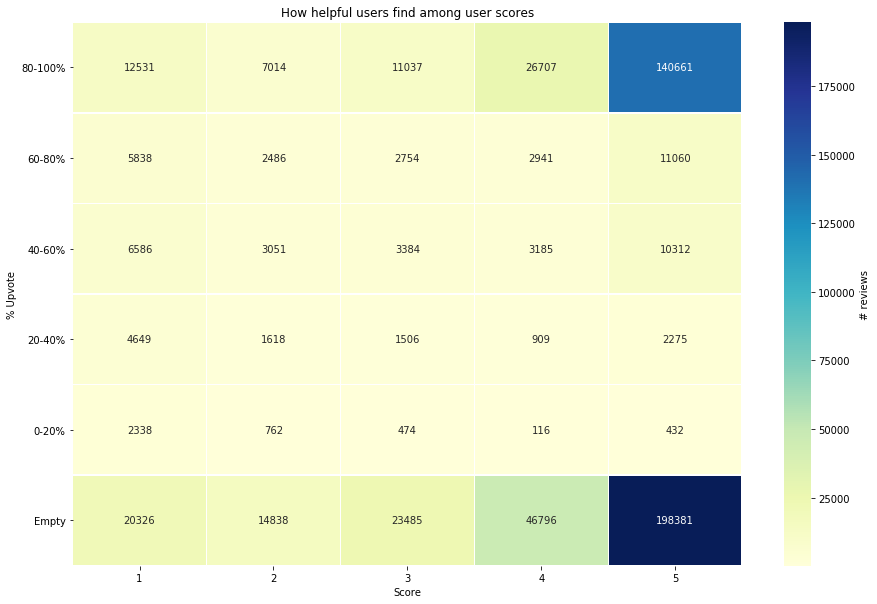

In [3]:
df_s = odf.groupby(['Score', '% Upvote']).agg({'Id': 'count'})
df_s = df_s.unstack()
df_s.columns = df_s.columns.get_level_values(1)
fig = plt.figure(figsize=(15,10))

sns.heatmap(df_s[df_s.columns[::-1]].T, cmap = 'YlGnBu', linewidths=.5, annot = True, fmt = 'd', cbar_kws={'label': '# reviews'})
plt.yticks(rotation=0)
plt.title('How helpful users find among user scores')

Key message from above:

Reviews are skewed towards positive

More than half of the reviews are with zero votes

Many people agree with score 5 reviews

In [4]:
df_s

% Upvote,Empty,0-20%,20-40%,40-60%,60-80%,80-100%
Score,,,,,,
1,20326,2338,4649,6586,5838,12531
2,14838,762,1618,3051,2486,7014
3,23485,474,1506,3384,2754,11037
4,46796,116,909,3185,2941,26707
5,198381,432,2275,10312,11060,140661


In [5]:
df = odf[odf['Score'] != 3]
X = df['Text']
y_dict = {1:0, 2:0, 4:1, 5:1}
y = df['Score'].map(y_dict)

# Score prediction

In [12]:
X.shape

(154428,)

In [14]:
y.value_counts()

1    151721
0      2707
Name: % Upvote, dtype: int64

Logistic regression model on word count


In [6]:
c = CountVectorizer(stop_words = 'english')

def text_fit(X, y, model,clf_model,coef_show=1):
    
    X_c = model.fit_transform(X)
    print('# features: {}'.format(X_c.shape[1]))
    X_train, X_test, y_train, y_test = train_test_split(X_c, y, random_state=0)
    print('# train records: {}'.format(X_train.shape[0]))
    print('# test records: {}'.format(X_test.shape[0]))
    clf = clf_model.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    print ('Model Accuracy: {}'.format(acc))
    
    if coef_show == 1: 
        w = model.get_feature_names()
        coef = clf.coef_.tolist()[0]
        coeff_df = pd.DataFrame({'Word' : w, 'Coefficient' : coef})
        coeff_df = coeff_df.sort_values(['Coefficient', 'Word'], ascending=[0, 1])
        print('')
        print('-Top 20 positive-')
        print(coeff_df.head(20).to_string(index=False))
        print('')
        print('-Top 20 negative-')        
        print(coeff_df.tail(20).to_string(index=False))
    
    
text_fit(X, y, c, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454


C:\Users\emondsa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\emondsa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model Accuracy: 0.9387085976843611

-Top 20 positive-
Coefficient           Word
   3.328455     pleasantly
   3.198078  emeraldforest
   3.017748        chedder
   2.562048        easiest
   2.452307        solving
   2.442939        blowout
   2.371637       heartier
   2.370786      addicting
   2.297525     unwrapping
   2.295164          herrs
   2.291846       drawback
   2.290115         hooked
   2.281839         skewed
   2.261691         hahaha
   2.249722       downside
   2.237218     correction
   2.192934          whisk
   2.188074         ration
   2.186462         bertie
   2.168194     dishwasher

-Top 20 negative-
Coefficient           Word
  -2.465560     unfinished
  -2.491154       tastless
  -2.597662        weakest
  -2.607482      overrated
  -2.692474      cancelled
  -2.730141    unappealing
  -2.741285        furious
  -2.752452     oversalted
  -2.821854      deceptive
  -2.822357  disappointing
  -2.825763    undrinkable
  -2.828221    embarrassed
  -2.8719

Accuracy is around 93.9% - not bad. However we notice that some of those significant coefficients are not meaningful, e.g. 280mg.

Let's also look at the base line accuracy (predicting with majority class, in this case positive class):

In [7]:
text_fit(X, y, c, DummyClassifier(),0)

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.7359152250977529


# Logistic regression model on TFIDF

In [8]:
tfidf = TfidfVectorizer(stop_words = 'english')
text_fit(X, y, tfidf, LogisticRegression())

# features: 114969
# train records: 394360
# test records: 131454
Model Accuracy: 0.9346691618360795

-Top 20 positive-
Coefficient        Word
  13.722046       great
  12.152403   delicious
  12.013716        best
  10.606932     perfect
   9.860662   excellent
   9.583118       loves
   9.037644      highly
   8.363588        love
   7.965187   wonderful
   7.797099     amazing
   7.629215     awesome
   7.339744        good
   7.242570  pleasantly
   7.188672        nice
   7.019284      hooked
   6.954268       yummy
   6.941714    favorite
   6.931324     pleased
   6.884063      smooth
   6.721716   fantastic

-Top 20 negative-
Coefficient            Word
  -5.624625           waste
  -5.720375            poor
  -5.722123     undrinkable
  -6.010274            yuck
  -6.152047           stale
  -6.281935           worse
  -6.323420           bland
  -6.556099      disgusting
  -6.563135            weak
  -6.688471          return
  -6.733337           threw
  -6.838208       tas

Accurancy is roughly the same - 93.5%. However we notice that the significant words make much more sense now, with higher coefficient magnitude as well!

# Logistic regression model on TFIDF + ngram

In [9]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')
text_fit(X, y, tfidf_n, LogisticRegression())

# features: 3933179
# train records: 394360
# test records: 131454
Model Accuracy: 0.9454714196601093

-Top 20 positive-
Coefficient              Word
  21.054577             great
  17.831601              best
  17.012872         delicious
  14.624623           perfect
  13.611160             loves
  13.272387              love
  13.144334         excellent
  11.418326              good
  11.321080         wonderful
  10.811514              nice
  10.594919          favorite
   9.691426           amazing
   9.371318           awesome
   9.143947              easy
   8.947594           pleased
   8.906614             happy
   8.715677            smooth
   8.592553             yummy
   8.466686            highly
   8.423070  highly recommend

-Top 20 negative-
Coefficient            Word
  -7.807009           maybe
  -8.129029          hoping
  -8.250228       tasteless
  -8.319548           money
  -8.353005           worse
  -8.564717         thought
  -8.764723      disgusting
  -9.1

Adding ngram parameter, we are able to understand phrase like "not good". Therefore the accuracy goes up a bit to 94.5%. We can see "highly recommend" is on 20th place of positive words

# Upvote prediction

Data preview

This study is to see whether there is pattern found for unpopular (downvote) comments by users (might be used to boost sales). We will be focusing on score 5 reviews, and get rid of comments with neutral votes:

In [10]:
df = df[df['Score'] == 5]
df = df[df['% Upvote'].isin(['0-20%', '20-40%', '60-80%', '80-100%'])]
df.shape

X = df['Text']
y_dict = {'0-20%': 0, '20-40%': 0, '60-80%': 1, '80-100%': 1}
y = df['% Upvote'].map(y_dict)

print('Class distribution:')
print(y.value_counts())

Class distribution:
1    151721
0      2707
Name: % Upvote, dtype: int64


The target class is highly skewed to positive (upvotes). Let's resample the data to get balanced data:

In [15]:
df_s = pd.DataFrame(data = [X,y]).T

Downvote_records = len(df_s[df_s['% Upvote'] == 0])
Downvote_indices = np.array(df_s[df_s['% Upvote'] == 0].index)

Upvote_indices = df_s[df_s['% Upvote'] == 1].index

random_upvote_indices = np.random.choice(Upvote_indices, Downvote_records, replace = False)
random_upvote_indices = np.array(random_upvote_indices)

under_sample_indices = np.concatenate([Downvote_indices,random_upvote_indices])

under_sample_data = df_s.ix[under_sample_indices, :]
X_u = under_sample_data['Text']
under_sample_data['% Upvote'] = under_sample_data['% Upvote'].astype(int)
y_u = under_sample_data['% Upvote']

print("Percentage of upvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 1])/len(under_sample_data))
print("Percentage of downvote transactions: ", len(under_sample_data[under_sample_data['% Upvote'] == 0])/len(under_sample_data))
print("Total number of records in resampled data: ", len(under_sample_data))

Percentage of upvote transactions:  0.5
Percentage of downvote transactions:  0.5
Total number of records in resampled data:  5414


C:\Users\emondsa\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  del sys.path[0]


In [17]:
df_s.head()

,Text,% Upvote
0,I have bought several of the Vitality canned d...,1
8,Right now I'm mostly just sprouting this so my...,1
10,I don't know if it's the cactus or the tequila...,1
11,One of my boys needed to lose some weight and ...,1
14,The Strawberry Twizzlers are my guilty pleasur...,1


# Logistic regression model on word count¶

In [18]:
c = CountVectorizer(stop_words = 'english')

text_fit(X_u, y_u, c, LogisticRegression())

# features: 16083
# train records: 4060
# test records: 1354
Model Accuracy: 0.7186115214180206

-Top 20 positive-
Coefficient        Word
   1.386899    fabulous
   1.332679      bitter
   1.286751    quantity
   1.195011    thinking
   1.180269  complaints
   1.173001     candies
   1.127016        heat
   1.118164        kick
   1.099103      single
   1.047862        chip
   1.042289        wont
   1.037449   packaging
   1.034932        bold
   1.029758      keurig
   1.026576        soon
   1.023699       rinse
   1.005445       eater
   0.996633      gluten
   0.987425  assortment
   0.981138      bodied

-Top 20 negative-
Coefficient         Word
  -0.951921           24
  -0.955369  opportunity
  -0.964114        wrong
  -0.967286         near
  -0.970077       newman
  -0.973061        pizza
  -0.985442       matter
  -0.990082        kashi
  -1.040698     kombucha
  -1.115425        given
  -1.130765       caviar
  -1.160597       lipton
  -1.188957        short
  -1.189118 

The words look no sense at all, and the coefficients are very small.

# Logistic regression model on TFIDF + ngram

In [19]:
tfidf_n = TfidfVectorizer(ngram_range=(1,2),stop_words = 'english')

text_fit(X_u, y_u, tfidf_n, LogisticRegression())

# features: 143723
# train records: 4060
# test records: 1354
Model Accuracy: 0.7193500738552437

-Top 20 positive-
Coefficient         Word
   2.050771         food
   1.755108          mix
   1.550919           ve
   1.417955       flavor
   1.379502          tea
   1.269297         make
   1.263598         salt
   1.112136       gluten
   1.069881         teas
   0.979712          bag
   0.972884      chicken
   0.972837        chips
   0.962782         does
   0.960645        fresh
   0.951459        tried
   0.951375      flavors
   0.941456        loves
   0.912046  gluten free
   0.910567         real
   0.908022      quality

-Top 20 negative-
Coefficient     Word
  -0.855027    wrong
  -0.885125   thanks
  -0.897356     nice
  -0.905060     yoga
  -0.924973     item
  -0.982030     wish
  -1.000560  pleased
  -1.028838   lipton
  -1.032415   bottle
  -1.091557   marley
  -1.122176   seller
  -1.166524     zico
  -1.194964  product
  -1.206812    order
  -1.234402  service
  -1

Similar to count metric, the accuracy isn't very high and words are not meaningful.

# Study on non-context features

Let's look at some examples of upvote and downvote comments:

In [20]:
#pd.set_option('display.max_colwidth', -1)
print('Downvote score 5 comments examples:')
print(under_sample_data[under_sample_data['% Upvote']==0]['Text'].iloc[:100:20])
print('Upvote score 5 comments examples')
print(under_sample_data[under_sample_data['% Upvote']==1]['Text'].iloc[:100:20])

Downvote score 5 comments examples:
207      Hard to find the wintergreen smalls [sugar fre...
4511     Wonderful, smooth, satisfying decaf coffee wit...
7787     My husband is a big coffee drinker, and with a...
12072    We love French roast coffee and my husband mus...
13671    THIS IS A LOVELY VERY HEALTHY TREE,ALONG WITH ...
Name: Text, dtype: object
Upvote score 5 comments examples
476165    I love this pasta.  I hate it when I go to my ...
327184    We have two bachon's Frise Dogs who just love ...
145844    I checked my past orders of the Stash brand Ea...
142252    Cheese?  I received a cheese of the month pack...
269951    Pro: Tastes fresh. Great stuff!<br /><br />Con...
Name: Text, dtype: object


Time to extract some possible features:

In [21]:
under_sample_data['word_count'] = under_sample_data['Text'].apply(lambda x: len(x.split()))
under_sample_data['capital_count'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c.isupper()))
under_sample_data['question_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '?'))
under_sample_data['exclamation_mark'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c == '!'))
under_sample_data['punctuation'] = under_sample_data['Text'].apply(lambda x: sum(1 for c in x if c in punctuation))

print(under_sample_data.groupby('% Upvote').agg({'word_count': 'mean', 'capital_count': 'mean', 'question_mark': 'mean', 'exclamation_mark': 'mean', 'punctuation': 'mean'}).T)

X_num = under_sample_data[under_sample_data.columns.difference(['% Upvote', 'Text'])]
y_num = under_sample_data['% Upvote']

% Upvote                  0          1
word_count        83.927226  88.032139
capital_count     19.252678  13.986701
question_mark      0.180273   0.084965
exclamation_mark   0.906169   0.912819
punctuation       22.482822  19.646842


In [24]:
X_num.head()

,capital_count,exclamation_mark,punctuation,question_mark,word_count
207,7,1,16,0,64
284,0,1,4,0,32
536,10,0,11,0,40
539,391,15,438,5,866
647,2,0,2,0,28


# Now we train the model to predict:

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_num, y_num, random_state=0)

clf_lr = LogisticRegression().fit(X_train, y_train)
acc_lr = clf_lr.score(X_test, y_test)
print('Logistic Regression accuracy: {}'.format(acc_lr))

clf_svm = svm.SVC().fit(X_train, y_train)
acc_svm = clf_svm.score(X_test, y_test)
print('SVM accuracy: {}'.format(acc_svm))

Logistic Regression accuracy: 0.5841949778434269


C:\Users\emondsa\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVM accuracy: 0.6639586410635155


Accuracy is lower than context features we tried above, meaning the feature is not good enough to predict our target.

# In-depth study on user behaviour

This analysis will be carried out to focus on one specific user, on what he / she likes in terms of fine food, based on the reviews he / she had given in the past. This can be expanded to all users later on.

First let's look at how many reviews each user gave in the past:

In [39]:
df_user = odf.groupby(['UserId', 'ProfileName']).agg({'Score':['count', 'mean']})
df_user.columns = df_user.columns.get_level_values(1)
df_user.columns = ['Score count', 'Score mean']
df_user = df_user.sort_values(by = 'Score count', ascending = False)
print(df_user.head(10))

                                                       Score count  Score mean
UserId         ProfileName                                                    
A3OXHLG6DIBRW8 C. F. Hill "CFH"                                448    4.535714
A1YUL9PCJR3JTY O. Brown "Ms. O. Khannah-Brown"                 421    4.494062
AY12DBB0U420B  Gary Peterson                                   389    4.647815
A281NPSIMI1C2R Rebecca of Amazon "The Rebecca Review"          365    4.841096
A1Z54EM24Y40LL c2                                              256    4.453125
A1TMAVN4CEM8U8 Gunner                                          204    4.833333
A2MUGFV2TDQ47K Lynrie "Oh HELL no"                             201    3.751244
A3TVZM3ZIXG8YW christopher hayes                               199    1.000000
A3PJZ8TU8FDQ1K Jared Castle                                    178    4.601124
AQQLWCMRNDFGI  Steven A. Peterson                              176    3.954545


The user with most frequent reviews are "CFH" with 448 reviews and average score 4.54. Let's look at his review distribution:

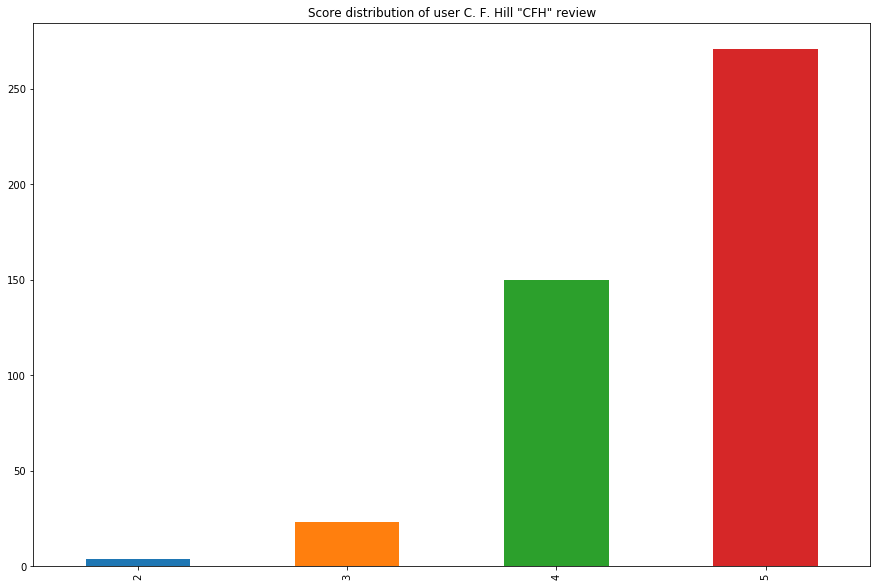

In [40]:
def plot_user(UserId):
    df_1user = odf[odf['UserId'] == UserId]['Score']
    df_1user_plot = df_1user.value_counts(sort=False)
    ax = df_1user_plot.plot(kind = 'bar', figsize = (15,10), title = 'Score distribution of user {} review'.format(odf[odf['UserId'] == UserId]['ProfileName'].iloc[0]))

plot_user('A3OXHLG6DIBRW8')

It looks user "CFH" prefer to give high score a lot. I would rather analyze a more neutral user, let's dig into that:

In [41]:
print(df_user[(df_user['Score mean']<3.5) & (df_user['Score mean']>2.5)].head())

                                Score count  Score mean
UserId         ProfileName                             
A35R32TA60XD57 M. Torma                 141    3.460993
A2M9D9BDHONV3Y A. Bennett               115    3.269565
A2TN9C5E4A0I3F Jimmy                    110    2.727273
A2XNJJ9TF70P4J Angie                     85    2.976471
AJB5P7GVR0MT8  Harry the Horse           70    3.257143


A. Bennett seems a good target:

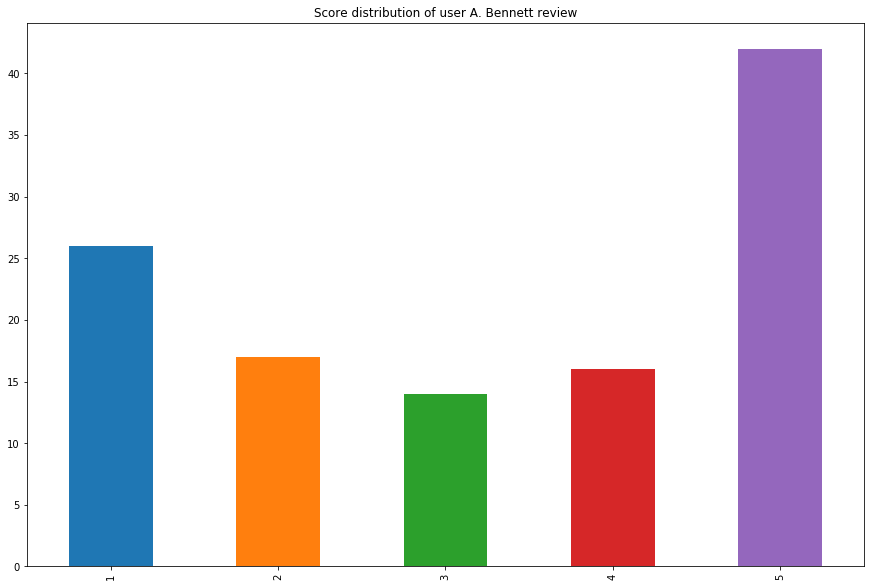

In [42]:
plot_user('A2M9D9BDHONV3Y')

He seems like a better analysis target! Now let's dig deep into his reviews:

In [52]:
def get_token_ngram(score, benchmark, userid='all'):

    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'v') for w in total_text]
    bigrams = ngrams(total_text,2)
    trigrams = ngrams(total_text, 3)

    # look at 2-gram and 3-gram together
    combine = chain(bigrams, trigrams)
    text = nltk.Text(combine)
    fdist = nltk.FreqDist(text)
    print("I heard",fdist)
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_ngram(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

I heard <FreqDist with 2144 samples and 3493 outcomes>
score 1 reviews most popular 2-gram / 3-gram:
   Count  Occur %                   Phrase
0   31.0  119.23%               (..., ...)
1   17.0   65.38%          (..., ..., ...)
2   11.0   42.31%             (never, buy)
3    9.0   34.62%           (buy, product)
4    8.0   30.77%    (never, buy, product)
5    8.0   30.77%  (monosodium, glutamate)
6    7.0   26.92%            (decide, try)
7    7.0   26.92%          (picture, look)
8    7.0   26.92%         (dry, tasteless)
I heard <FreqDist with 1702 samples and 2007 outcomes>
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %                Phrase
0     8.0  47.06%  (sauce, ruin, whole)
1     8.0  47.06%         (sauce, ruin)
2     8.0  47.06%         (ruin, whole)
3     6.0  35.29%            (n't, buy)
4     6.0  35.29%       (product, ever)
5     5.0  29.41%     (..., .give, try)
6     5.0  29.41%           (try, like)
7     5.0  29.41%    (.give, try, like)
8     5.

Seems like A. Bennett likes to use something like "give it a try" for score 2 reviews and "highly recommend" for score 5 reviews (without other frequent phrases). He likes using the phrase "..." a lot as well. Sample size is very small though.

Let's look at full picture now instead of just one user:

In [46]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    # easier benchmark since we have many different users here, thus different phrase
    d = get_token_ngram(j, 0.03)
    print('score {} reviews most popular 2-gram / 3-gram:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  5536.0  10.59%   (taste, like)
1  2316.0   4.43%  (waste, money)
2  2175.0   4.16%    (could, n't)
3  2111.0   4.04%     (n't, even)
4  1809.0   3.46%     (n't, know)
5  1794.0   3.43%    (would, n't)
6  1644.0   3.15%      (n't, buy)
score 2 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  3161.0  10.62%   (taste, like)
1  1362.0   4.58%     (n't, like)
2  1304.0   4.38%    (would, n't)
3  1086.0   3.65%  (think, would)
4  1064.0   3.57%      (n't, buy)
5  1010.0   3.39%     (n't, know)
6   996.0   3.35%    (n't, taste)
7   945.0   3.17%    (could, n't)
8   910.0   3.06%   (taste, good)
score 3 reviews most popular 2-gram / 3-gram:
    Count Occur %          Phrase
0  3237.0   7.59%   (taste, like)
1  1632.0   3.83%    (would, n't)
2  1612.0   3.78%     (n't, like)
3  1551.0   3.64%   (taste, good)
4  1463.0   3.43%   (href=, http)
5  1406.0    3.3%     (n't, know)
6  1295.0   

Funny that people are more likely to attach HTML links (href=) for more positive reviews (3 and 4).
Other than that, not much useful discoveries except positive / negative tones, since people are very different in texting style.

Maybe we should focus on popular single adjective word people used for different score. First we modify the function a bit for easier implementation:

In [47]:
def get_token_adj(score, benchmark, userid='all'):
    
    if userid != 'all':
        df = odf[(odf['UserId'] == userid) & (odf['Score'] == score)]['Text']
    else:
        df = odf[odf['Score'] == score]['Text']
        
    count = len(df)
    total_text = ' '.join(df)
    total_text = total_text.lower()
    stop = set(stopwords.words('english'))
    total_text = nltk.word_tokenize(total_text)
    total_text = [word for word in total_text if word not in stop and len(word) >= 3]
    lemmatizer = WordNetLemmatizer()
    total_text = [lemmatizer.lemmatize(w,'a') for w in total_text]
    # get adjective only
    total_text = [word for word, form in nltk.pos_tag(total_text) if form == 'JJ']
    
    text = nltk.Text(total_text)
    fdist = nltk.FreqDist(text)
    
    # return only phrase occurs more than benchmark of his reviews
    return sorted([(w,fdist[w],str(round(fdist[w]/count*100,2))+'%') for w in set(text) if fdist[w] >= count*benchmark], key=lambda x: -x[1])

Let's look at user A. Bennett again:

In [50]:
import nltk
nltk.download('averaged_perceptron_tagger')
# score 1-5 reviews with this user
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.25, 'A2M9D9BDHONV3Y')
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\emondsa\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.


score 1 reviews most popular adjectives word:
   Count Occur %     Phrase
0   13.0   50.0%        dry
1   12.0  46.15%     cheese
2   10.0  38.46%        bad
3   10.0  38.46%     little
4    8.0  30.77%  expensive
5    8.0  30.77%       hard
6    8.0  30.77%      tasty
7    8.0  30.77%  delicious
8    7.0  26.92%       poor
9    7.0  26.92%      bread
score 2 reviews most popular adjectives word:
   Count Occur %      Phrase
0   10.0  58.82%       whole
1    8.0  47.06%      cheese
2    6.0  35.29%       wrong
3    6.0  35.29%       awful
4    6.0  35.29%   delicious
5    5.0  29.41%  particular
6    5.0  29.41%       .give
7    5.0  29.41%        good
score 3 reviews most popular adjectives word:
   Count Occur %        Phrase
0    9.0  64.29%         whole
1    5.0  35.71%          high
2    4.0  28.57%         great
3    4.0  28.57%  disappointed
4    4.0  28.57%         first
5    4.0  28.57%          good
score 4 reviews most popular adjectives word:
   Count Occur %     Phrase
0 

Obviously much more useful information here, e.g. A. Bennett hates food that are too dry and expensive
Let's also look at big picture:

In [51]:
# score 1-5 reviews with all users
index = ['Phrase', 'Count', 'Occur %']

for j in range(1,6):
    test = pd.DataFrame()
    d = get_token_adj(j, 0.05)
    print('score {} reviews most popular adjectives word:'.format(j))
    for i in d:
        test = test.append(pd.Series(i, index = index), ignore_index = True)
    test = test.sort_values('Count', ascending=False)
    print(test)

score 1 reviews most popular adjectives word:
      Count Occur %        Phrase
0   16193.0  30.98%          good
1   10777.0  20.62%           bad
2    4977.0   9.52%         great
3    4844.0   9.27%          much
4    4786.0   9.16%        little
5    4774.0   9.13%           old
6    4198.0   8.03%         first
7    3956.0   7.57%           new
8    3789.0   7.25%     different
9    3717.0   7.11%          many
10   3537.0   6.77%         small
11   3296.0   6.31%          real
12   3000.0   5.74%  disappointed
13   2884.0   5.52%          sure
14   2831.0   5.42%          free
15   2823.0    5.4%          diet
16   2761.0   5.28%          high
17   2658.0   5.09%          last
score 2 reviews most popular adjectives word:
      Count Occur %        Phrase
0   13525.0  45.43%          good
1    4251.0  14.28%          much
2    4170.0  14.01%           bad
3    3909.0  13.13%         great
4    3691.0   12.4%        little
5    2847.0   9.56%         small
6    2323.0    7.8%     